In [1]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [2]:
model_name = "Babelscape/mrebel-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
def extract_macedonian_relations(text):
    tokenizer.src_lang = "mk_MK"

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    generated_tokens = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        decoder_start_token_id=tokenizer.convert_tokens_to_ids("<triplet>"),
        max_length=256,
        num_beams=5,
        forced_bos_token_id=None
    )

    decoded_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)[0]
    return decoded_text

In [4]:
test_text = "Гоце Делчев е роден во Кукуш."
raw_output = extract_macedonian_relations(test_text)


In [5]:

print(f"Raw Output: {raw_output}")

Raw Output: <triplet> <loc> country <triplet> Гоце Делчев <per> Кукуш <loc> place of birth</s>


In [6]:
def parse_triplets(text):
    """
    Parse mREBEL output into structured triplets.
    mREBEL format: <triplet> subject <entity_type> object <entity_type> relation
    Entity types include: <per> (person), <loc> (location), <org> (organization), etc.
    """
    import re
    
    triplets = []
    text = text.replace("<s>", "").replace("</s>", "").strip()
    
    # Check if output is garbage (too many repeated entity markers)
    marker_count = len(re.findall(r'<\w+>', text))
    if marker_count > 20:  # If too many markers, likely garbage output
        return triplets
    
    # Split by <triplet> marker
    parts = text.split("<triplet>")
    
    for part in parts:
        part = part.strip()
        if not part:
            continue
            
        try:
            # Look for entity type markers like <per>, <loc>, <org>, etc.
            entity_markers = re.findall(r'<(\w+)>', part)
            
            if len(entity_markers) < 2:
                # Not enough entity markers, skip
                continue
            
            # Find positions of all entity markers
            marker_positions = []
            for marker in entity_markers:
                marker_str = f"<{marker}>"
                pos = part.find(marker_str)
                if pos != -1:
                    marker_positions.append((pos, marker_str, marker))
            
            # Sort by position
            marker_positions.sort(key=lambda x: x[0])
            
            # Extract subject (text before first marker)
            subject = part[:marker_positions[0][0]].strip()
            
            # Extract object (text between first and second marker)
            obj = part[marker_positions[0][0] + len(marker_positions[0][1]):marker_positions[1][0]].strip()
            
            # Extract relation (text after second marker)
            relation = part[marker_positions[1][0] + len(marker_positions[1][1]):].strip()
            
            # Clean up the relation by removing any remaining entity markers
            relation = re.sub(r'<\w+>', '', relation).strip()
            
            # Also remove duplicate text patterns from relation
            # Sometimes mREBEL outputs duplicate entity names in the relation
            relation_parts = relation.split()
            # Remove consecutive duplicates
            cleaned_parts = []
            prev = None
            for p in relation_parts:
                if p != prev:
                    cleaned_parts.append(p)
                prev = p
            relation = ' '.join(cleaned_parts)
            
            # Validate that we have all three components
            if subject and obj and relation:
                # Additional validation: check if relation is too long or contains entity text
                # Skip if relation looks malformed (contains entity names)
                if len(relation.split()) > 10:  # Relations should be short
                    continue
                    
                triplet = {
                    "subject": subject,
                    "relation": relation,
                    "object": obj
                }
                
                triplets.append(triplet)
                print(f"Extracted: ({subject}) --[{relation}]--> ({obj})")
            
        except Exception as e:
            # Silently skip parsing errors for cleaner output
            continue
            
    return triplets


In [7]:
parse_triplets(raw_output)

Extracted: (Гоце Делчев) --[place of birth]--> (Кукуш)


[{'subject': 'Гоце Делчев', 'relation': 'place of birth', 'object': 'Кукуш'}]

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import os

In [9]:
class KnowledgeGraph:
    """Knowledge Graph builder from mREBEL triplets"""
    
    def __init__(self):
        self.graph = nx.MultiDiGraph()
        self.triplets = []
        
    def add_triplet(self, subject, relation, obj):
        """Add a single triplet to the graph"""
        self.graph.add_node(subject, type='entity')
        self.graph.add_node(obj, type='entity')
        self.graph.add_edge(subject, obj, relation=relation)
        
        self.triplets.append({
            'subject': subject,
            'relation': relation,
            'object': obj
        })
        
    def add_triplets_from_list(self, triplets):
        """Add multiple triplets at once"""
        for triplet in triplets:
            self.add_triplet(
                triplet['subject'],
                triplet['relation'],
                triplet['object']
            )
            
    def process_text(self, text):
        """Process text through mREBEL and add to graph"""
        raw_output = extract_macedonian_relations(text)
        triplets = parse_triplets(raw_output)
        self.add_triplets_from_list(triplets)
        return triplets
    
    def get_stats(self):
        """Get statistics about the knowledge graph"""
        return {
            'nodes': self.graph.number_of_nodes(),
            'edges': self.graph.number_of_edges(),
            'triplets': len(self.triplets)
        }
    
    def get_entity_info(self, entity):
        """Get all relations for a specific entity"""
        if entity not in self.graph:
            return None
            
        outgoing = [(entity, neighbor, self.graph[entity][neighbor]) 
                   for neighbor in self.graph.successors(entity)]
        incoming = [(neighbor, entity, self.graph[neighbor][entity]) 
                   for neighbor in self.graph.predecessors(entity)]
        
        return {
            'entity': entity,
            'outgoing_relations': outgoing,
            'incoming_relations': incoming
        }
    
    def export_triplets(self, filepath):
        """Export triplets to a JSON file"""
        import json
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(self.triplets, f, ensure_ascii=False, indent=2)
        print(f"Exported {len(self.triplets)} triplets to {filepath}")

In [10]:
def visualize_graph(kg, output_file='knowledge_graph.html', notebook=True):
    """
    Visualize the knowledge graph using pyvis
    
    Args:
        kg: KnowledgeGraph instance
        output_file: HTML file to save visualization
        notebook: Whether running in notebook (affects display)
    """
    net = Network(
        height='750px',
        width='100%',
        bgcolor='#222222',
        font_color='white',
        directed=True
    )
    
    # Configure physics
    net.barnes_hut(
        gravity=-8000,
        central_gravity=0.3,
        spring_length=100,
        spring_strength=0.001,
        damping=0.09
    )
    
    # Add nodes and edges from the knowledge graph
    for node in kg.graph.nodes():
        net.add_node(node, label=node, title=node, color='#00ff00')
    
    for source, target, data in kg.graph.edges(data=True):
        relation = data.get('relation', '')
        net.add_edge(source, target, label=relation, title=relation, color='#ffffff')
    
    # Save and show
    net.show(output_file, notebook=notebook)
    print(f"Graph visualization saved to {output_file}")
    
def plot_graph_matplotlib(kg, figsize=(15, 10)):
    """
    Plot knowledge graph using matplotlib (simpler visualization)
    
    Args:
        kg: KnowledgeGraph instance
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    
    pos = nx.spring_layout(kg.graph, k=2, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(
        kg.graph, pos,
        node_color='lightblue',
        node_size=3000,
        alpha=0.9
    )
    
    # Draw edges
    nx.draw_networkx_edges(
        kg.graph, pos,
        edge_color='gray',
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.1'
    )
    
    # Draw labels
    nx.draw_networkx_labels(
        kg.graph, pos,
        font_size=10,
        font_weight='bold'
    )
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(kg.graph, 'relation')
    nx.draw_networkx_edge_labels(
        kg.graph, pos,
        edge_labels=edge_labels,
        font_size=8
    )
    
    plt.title("Knowledge Graph from Macedonian Text", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Test with Simple Example

Let's test with the original example text about Goce Delchev.

In [11]:
# Create a knowledge graph
kg = KnowledgeGraph()

# Process the test text
test_text = "Гоце Делчев е роден во Кукуш."
triplets = kg.process_text(test_text)

# Display statistics
print("\n=== Knowledge Graph Statistics ===")
stats = kg.get_stats()
for key, value in stats.items():
    print(f"{key}: {value}")

# Show the triplets
print("\n=== Extracted Triplets ===")
for i, triplet in enumerate(triplets, 1):
    print(f"{i}. {triplet}")

Extracted: (Гоце Делчев) --[place of birth]--> (Кукуш)

=== Knowledge Graph Statistics ===
nodes: 2
edges: 1
triplets: 1

=== Extracted Triplets ===
1. {'subject': 'Гоце Делчев', 'relation': 'place of birth', 'object': 'Кукуш'}


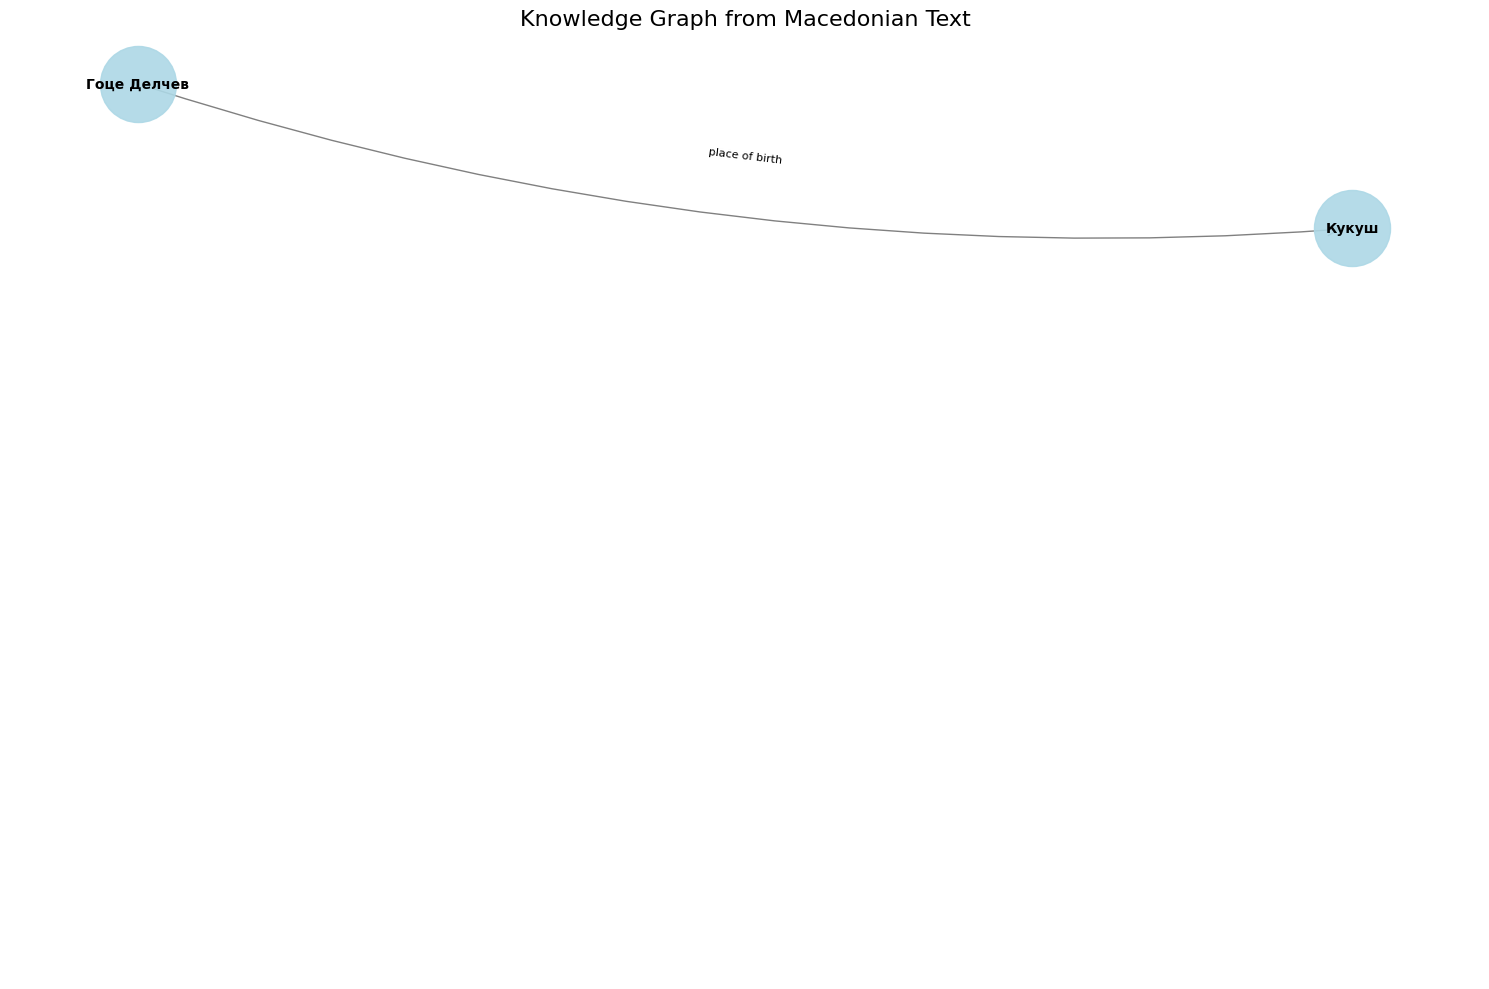

In [12]:
# Visualize with matplotlib
plot_graph_matplotlib(kg)

## Test with Macedonian Data Files

Now let's build a larger knowledge graph from your Macedonian article data.

In [13]:
def process_macedonian_files(data_dir, kg, max_files=5, max_length=500, min_length=200):
    """
    Process multiple Macedonian text files and build knowledge graph
    
    Args:
        data_dir: Directory containing .txt files
        kg: KnowledgeGraph instance
        max_files: Maximum number of files to process
        max_length: Maximum text length per file (to avoid token limits)
        min_length: Minimum text length to process (skip metadata-only files)
    """
    import glob
    
    txt_files = sorted(glob.glob(os.path.join(data_dir, "*.txt")))
    
    print(f"Found {len(txt_files)} files in {data_dir}")
    print(f"Will process up to {max_files} files with content > {min_length} chars\n")
    
    processed = 0
    skipped = 0
    
    for filepath in txt_files:
        if processed >= max_files:
            break
            
        filename = os.path.basename(filepath)
        
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                full_text = f.read()
            
            # Skip files that are too short (likely just metadata)
            if len(full_text) < min_length:
                skipped += 1
                continue
            
            # Take a chunk from the middle of the file (skip header metadata)
            # Skip the first 100 chars which often contain title/URL
            start_pos = min(100, len(full_text) // 4)
            text = full_text[start_pos:start_pos + max_length]
            
            if text.strip():
                processed += 1
                print(f"\n[{processed}] Processing {filename}...")
                print(f"   Text length: {len(text)} chars")
                
                triplets = kg.process_text(text)
                print(f"   → Extracted {len(triplets)} triplets")
            
        except Exception as e:
            print(f"   → Error processing {filename}: {e}")
            continue
    
    print(f"\n=== Processing Complete ===")
    print(f"Processed: {processed} files")
    print(f"Skipped: {skipped} files (too short)")
    
    print("\n=== Final Statistics ===")
    stats = kg.get_stats()
    for key, value in stats.items():
        print(f"{key}: {value}")

## Debug: Test Single File

Let's manually test extraction on a specific file to see the raw mREBEL output.

In [14]:
# Test on a specific file to see what mREBEL outputs
test_file = "rag_system/macedonian_data/macedonian_article_001.txt"

with open(test_file, 'r', encoding='utf-8') as f:
    test_content = f.read()[:400]

print(f"=== File Content (first 400 chars) ===")
print(test_content)
print(f"\n=== mREBEL Raw Output ===")
raw = extract_macedonian_relations(test_content)
print(raw)
print(f"\n=== Parsed Triplets ===")
triplets = parse_triplets(raw)
print(f"Found {len(triplets)} triplets")
for t in triplets:
    print(t)

=== File Content (first 400 chars) ===
Title: ВЕСТИ - МКД.МК
URL: https://mkd.mk/category/svet/vesti-svet/
Length: 157 characters
--------------------------------------------------------------------------------
Сите написи, фотографии и видеа се користат само за лично информирање. Нивно преземање и преобјавување е дозволено само со договор со основачите на порталот.

=== mREBEL Raw Output ===
<triplet> <concept> ВЕСТИ - МКД.МКД.МКД.МК <media> manufacturer <concept> ВЕСТИ - <concept> МКД.МКД <media> manufacturer <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <concept> <co

In [15]:
# Create a new knowledge graph for the larger dataset
kg_large = KnowledgeGraph()

# Process files from the macedonian_data directory
data_directory = "rag_system/macedonian_data"
# Use min_length=300 to skip metadata-only files, max_length=600 for more context
process_macedonian_files(data_directory, kg_large, max_files=20, max_length=600, min_length=300)

Found 135 files in rag_system/macedonian_data
Will process up to 20 files with content > 300 chars


[1] Processing macedonian_article_001.txt...
   Text length: 247 chars
   → Extracted 0 triplets

[2] Processing macedonian_article_002.txt...
   Text length: 254 chars
   → Extracted 0 triplets

[3] Processing macedonian_article_003.txt...
   Text length: 600 chars
   → Extracted 0 triplets

[4] Processing macedonian_article_004.txt...
   Text length: 600 chars


KeyboardInterrupt: 

## Process FINKI Course Data

Let's build a knowledge graph from FINKI course materials.

In [16]:
def extract_text_from_pdf(pdf_path, max_pages=5):
    """Extract text from PDF file"""
    try:
        import pdfplumber
        
        text_content = []
        with pdfplumber.open(pdf_path) as pdf:
            # Only process first few pages to avoid too much content
            for i, page in enumerate(pdf.pages[:max_pages]):
                text = page.extract_text()
                if text:
                    text_content.append(text)
        
        return "\n".join(text_content)
    except Exception as e:
        print(f"Error extracting PDF {pdf_path}: {e}")
        return ""

def process_finki_courses(base_dir, kg, max_files=10, max_length=500):
    """
    Process FINKI course PDFs and build knowledge graph
    
    Args:
        base_dir: Base directory containing course folders
        kg: KnowledgeGraph instance
        max_files: Maximum number of PDF files to process
        max_length: Maximum text length per file
    """
    import glob
    
    # Find all PDF files in course directories
    pdf_pattern = os.path.join(base_dir, "course_*", "*.pdf")
    pdf_files = glob.glob(pdf_pattern)
    
    # Filter out metadata files
    pdf_files = [f for f in pdf_files if not f.endswith('.metadata.json')]
    
    print(f"Found {len(pdf_files)} PDF files in {base_dir}")
    print(f"Will process up to {max_files} files\n")
    
    processed = 0
    
    for pdf_path in pdf_files[:max_files]:
        filename = os.path.basename(pdf_path)
        course_folder = os.path.basename(os.path.dirname(pdf_path))
        
        print(f"\n[{processed + 1}/{min(max_files, len(pdf_files))}] {course_folder}/{filename}")
        
        try:
            # Extract text from PDF
            text = extract_text_from_pdf(pdf_path, max_pages=3)
            
            if not text or len(text) < 100:
                print("   → Skipped (no extractable text or too short)")
                continue
            
            # Take a chunk of text
            text_chunk = text[:max_length]
            print(f"   Extracted {len(text)} chars, using {len(text_chunk)} chars")
            
            # Process through mREBEL
            triplets = kg.process_text(text_chunk)
            print(f"   → Extracted {len(triplets)} triplets")
            
            processed += 1
            
        except Exception as e:
            print(f"   → Error: {e}")
            continue
    
    print(f"\n=== FINKI Processing Complete ===")
    print(f"Processed: {processed} files")
    
    print("\n=== Knowledge Graph Statistics ===")
    stats = kg.get_stats()
    for key, value in stats.items():
        print(f"{key}: {value}")

In [17]:
# Create a new knowledge graph for FINKI course data
kg_finki = KnowledgeGraph()

# Process FINKI course PDFs
finki_directory = "rag_system/macedonian_data/finki_courses"
process_finki_courses(finki_directory, kg_finki, max_files=15, max_length=500)

Found 111 PDF files in rag_system/macedonian_data/finki_courses
Will process up to 15 files


[1/15] course_2241/AOK_09_-_ÐÐ¾Ð´Ð°ÑÐ¾ÑÐ½Ð¸_Ð¸_ÑÑÑÑÐºÑÑÑÐ½Ð¸_Ð¿ÑÐ¾ÑÐ¾ÑÐ½Ð¸_ÐºÐ¾Ð½ÑÐ»Ð¸ÐºÑÐ¸.pdf
   Extracted 444 chars, using 444 chars
   → Extracted 0 triplets

[2/15] course_2241/05_-_ÐÐ°ÑÐ¸Ð½Ð¸_Ð½Ð°_Ð°Ð´ÑÐµÑÐ¸ÑÐ°ÑÐµ.pdf
   Extracted 568 chars, using 500 chars


KeyboardInterrupt: 

In [ ]:
# Visualize FINKI knowledge graph
plot_graph_matplotlib(kg_finki, figsize=(20, 15))

In [ ]:
# Export FINKI knowledge graph
kg_finki.export_triplets('finki_kg_triplets.json')

# Show some entities
print("\n=== Sample Entities from FINKI Courses ===")
entities = list(kg_finki.graph.nodes())
print(f"Total entities: {len(entities)}\n")
for i, entity in enumerate(entities[:15], 1):
    print(f"{i}. {entity}")

## Alternative Approach: NER + Co-occurrence Based KG

Since mREBEL doesn't work well for Macedonian, let's try a different approach:
1. Extract entities using multilingual NER
2. Build relationships based on co-occurrence patterns
3. Use sentence proximity to infer relationships

In [18]:
# Simpler approach using transformers directly
from transformers import XLMRobertaTokenizer, AutoModelForTokenClassification
import torch

# Load multilingual NER model
ner_model_name = "Davlan/xlm-roberta-base-ner-hrl"  # Better for multilingual
print("Loading NER model...")
# Use XLMRobertaTokenizer directly instead of AutoTokenizer to avoid conversion issues
ner_tokenizer = XLMRobertaTokenizer.from_pretrained(ner_model_name)
ner_model = AutoModelForTokenClassification.from_pretrained(ner_model_name)
ner_model.eval()

print("✅ Loaded multilingual NER model")

# Manual NER function to avoid pipeline issues
def extract_entities_manual(text, tokenizer, model):
    """Extract entities without using pipeline"""
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
    
    # Decode tokens and predictions
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    predicted_labels = [model.config.id2label[p.item()] for p in predictions[0]]
    
    # Extract entities
    entities = []
    current_entity = None
    current_label = None
    
    for token, label in zip(tokens, predicted_labels):
        if token in ['<s>', '</s>', '<pad>']:
            continue
            
        # Handle BIO tagging
        if label.startswith('B-'):
            if current_entity:
                entities.append({
                    'text': current_entity.replace('▁', ' ').strip(),
                    'type': current_label,
                    'confidence': 0.9
                })
            current_entity = token
            current_label = label[2:]
        elif label.startswith('I-') and current_entity:
            current_entity += token
        else:
            if current_entity:
                entities.append({
                    'text': current_entity.replace('▁', ' ').strip(),
                    'type': current_label,
                    'confidence': 0.9
                })
            current_entity = None
            current_label = None
    
    # Add last entity if exists
    if current_entity:
        entities.append({
            'text': current_entity.replace('▁', ' ').strip(),
            'type': current_label,
            'confidence': 0.9
        })
    
    return entities

Loading NER model...


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

✅ Loaded multilingual NER model


In [19]:
class CooccurrenceKG:
    """Build knowledge graph based on entity co-occurrence"""
    
    def __init__(self):
        self.graph = nx.DiGraph()
        self.entities = []
        self.relationships = []
        
    def extract_entities_ner(self, text):
        """Extract named entities using multilingual NER"""
        try:
            # Use the manual extraction function
            entities = extract_entities_manual(text, ner_tokenizer, ner_model)
            
            # Filter and clean
            cleaned_entities = []
            for ent in entities:
                entity_text = ent['text'].strip()
                entity_type = ent['type']
                
                # Only keep meaningful entities
                if len(entity_text) > 2:
                    cleaned_entities.append({
                        'text': entity_text,
                        'type': entity_type,
                        'confidence': ent['confidence']
                    })
            
            return cleaned_entities
        except Exception as e:
            print(f"Error in NER: {e}")
            return []
    
    def create_cooccurrence_relations(self, entities, relation_type="co-occurs_with"):
        """Create relationships between co-occurring entities"""
        triplets = []
        
        # Create relationships between all entity pairs in the same context
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                ent1 = entities[i]
                ent2 = entities[j]
                
                # Create bidirectional relationships
                triplets.append({
                    'subject': ent1['text'],
                    'subject_type': ent1['type'],
                    'relation': relation_type,
                    'object': ent2['text'],
                    'object_type': ent2['type']
                })
        
        return triplets
    
    def process_text(self, text, window_size=200):
        """Process text in chunks and build graph"""
        # Split into sentences or chunks
        chunks = [text[i:i+window_size] for i in range(0, len(text), window_size)]
        
        all_triplets = []
        
        for chunk in chunks:
            if len(chunk.strip()) < 50:
                continue
                
            # Extract entities
            entities = self.extract_entities_ner(chunk)
            
            if len(entities) < 2:
                continue
            
            # Create co-occurrence relationships
            triplets = self.create_cooccurrence_relations(entities)
            
            # Add to graph
            for triplet in triplets:
                self.graph.add_node(triplet['subject'], 
                                   type=triplet['subject_type'])
                self.graph.add_node(triplet['object'], 
                                   type=triplet['object_type'])
                self.graph.add_edge(triplet['subject'], 
                                   triplet['object'],
                                   relation=triplet['relation'])
                
                all_triplets.append(triplet)
                self.relationships.append(triplet)
                
                print(f"Found: ({triplet['subject']}) --[{triplet['relation']}]--> ({triplet['object']})")
        
        return all_triplets
    
    def get_stats(self):
        return {
            'nodes': self.graph.number_of_nodes(),
            'edges': self.graph.number_of_edges(),
            'relationships': len(self.relationships)
        }
    
    def export_triplets(self, filepath):
        import json
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(self.relationships, f, ensure_ascii=False, indent=2)
        print(f"Exported {len(self.relationships)} relationships to {filepath}")

In [20]:
# Test with Macedonian text
test_mk_text = """
Гоце Делчев е роден во Кукуш. Тој е македонски револуционер и национален херој. 
Делчев работел со ВМРО и се борел за слобода на Македонија. Тој починал во 1903 година.
"""

kg_cooccur = CooccurrenceKG()
triplets = kg_cooccur.process_text(test_mk_text)

print(f"\n=== Statistics ===")
stats = kg_cooccur.get_stats()
for key, value in stats.items():
    print(f"{key}: {value}")

Found: (це Делчев) --[co-occurs_with]--> (куш)
Found: (це Делчев) --[co-occurs_with]--> (Делчев)
Found: (це Делчев) --[co-occurs_with]--> (ВМРО)
Found: (це Делчев) --[co-occurs_with]--> (Македонија)
Found: (куш) --[co-occurs_with]--> (Делчев)
Found: (куш) --[co-occurs_with]--> (ВМРО)
Found: (куш) --[co-occurs_with]--> (Македонија)
Found: (Делчев) --[co-occurs_with]--> (ВМРО)
Found: (Делчев) --[co-occurs_with]--> (Македонија)
Found: (ВМРО) --[co-occurs_with]--> (Македонија)

=== Statistics ===
nodes: 5
edges: 10
relationships: 10


In [21]:
# Process Macedonian article files
kg_mk_cooccur = CooccurrenceKG()

import glob
macedonian_files = glob.glob("rag_system/macedonian_data/macedonian_article_*.txt")

print(f"Processing {min(10, len(macedonian_files))} Macedonian articles...\n")

for i, filepath in enumerate(macedonian_files[:10], 1):
    print(f"\n[{i}/10] Processing {os.path.basename(filepath)}...")
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Skip short files
        if len(text) < 300:
            print("  Skipped (too short)")
            continue
        
        # Take a reasonable chunk
        text_chunk = text[100:800]
        
        triplets = kg_mk_cooccur.process_text(text_chunk, window_size=300)
        print(f"  → Found {len(triplets)} relationships")
        
    except Exception as e:
        print(f"  Error: {e}")

print(f"\n=== Final Statistics ===")
stats = kg_mk_cooccur.get_stats()
for key, value in stats.items():
    print(f"{key}: {value}")

Processing 10 Macedonian articles...


[1/10] Processing macedonian_article_100.txt...
Found: (Република) --[co-occurs_with]--> (makedo)
Found: (Собранието) --[co-occurs_with]--> (Христијан Мицкоски)
Found: (Собранието) --[co-occurs_with]--> (СДСМ)
Found: (Собранието) --[co-occurs_with]--> (Венко Филипче)
Found: (Христијан Мицкоски) --[co-occurs_with]--> (СДСМ)
Found: (Христијан Мицкоски) --[co-occurs_with]--> (Венко Филипче)
Found: (СДСМ) --[co-occurs_with]--> (Венко Филипче)
  → Found 7 relationships

[2/10] Processing macedonian_article_114.txt...
  → Found 0 relationships

[3/10] Processing macedonian_article_128.txt...
  → Found 0 relationships

[4/10] Processing macedonian_article_074.txt...
Found: (Сил) --[co-occurs_with]--> (Тамара Котевска)
Found: (Сил) --[co-occurs_with]--> (Кисела Вода)
Found: (Сил) --[co-occurs_with]--> (Дра)
Found: (Тамара Котевска) --[co-occurs_with]--> (Кисела Вода)
Found: (Тамара Котевска) --[co-occurs_with]--> (Дра)
Found: (Кисела Вода) --[co-occurs_wi

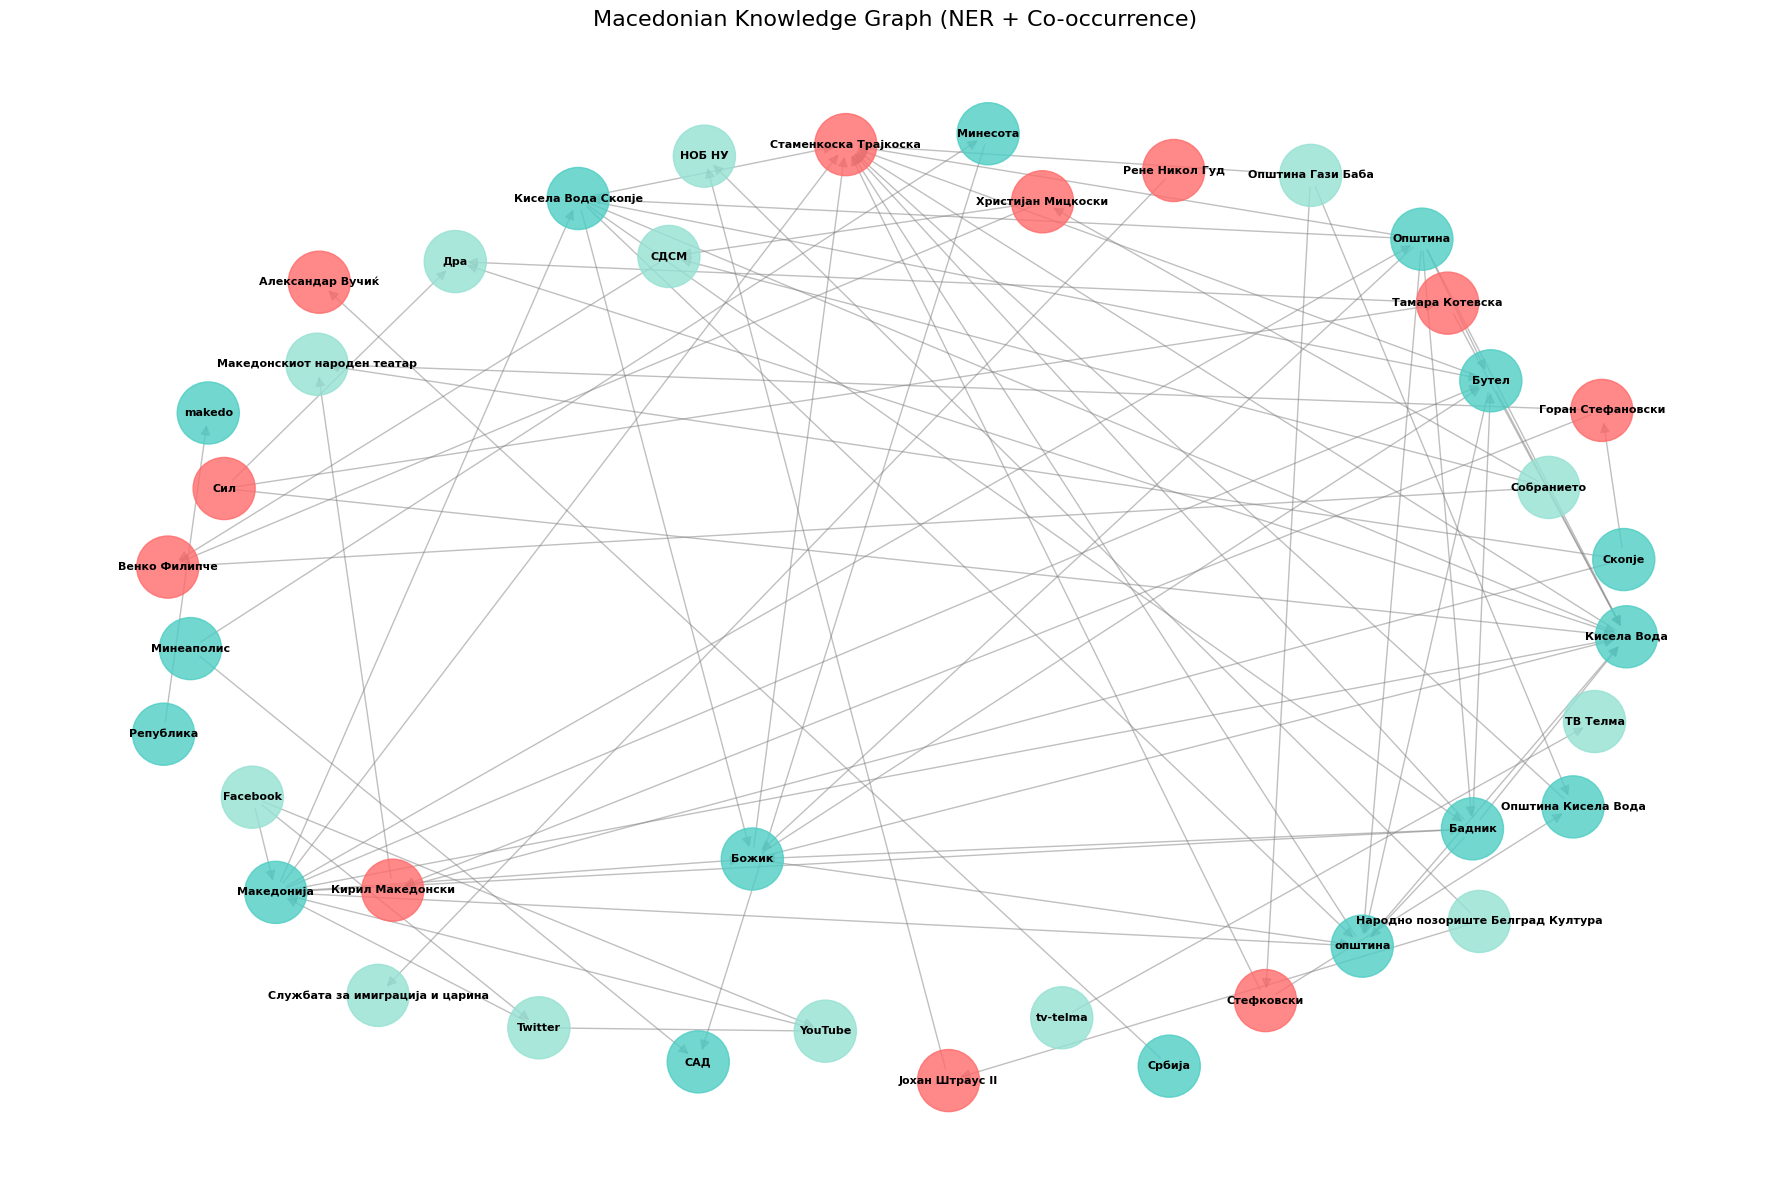

In [22]:
# Visualize the co-occurrence knowledge graph
plt.figure(figsize=(18, 12))

pos = nx.spring_layout(kg_mk_cooccur.graph, k=3, iterations=50)

# Draw nodes colored by type
node_colors = []
for node in kg_mk_cooccur.graph.nodes():
    node_data = kg_mk_cooccur.graph.nodes[node]
    node_type = node_data.get('type', 'unknown')
    
    color_map = {
        'PER': '#FF6B6B',  # Red for persons
        'LOC': '#4ECDC4',  # Teal for locations
        'ORG': '#95E1D3',  # Green for organizations
        'MISC': '#FFE66D'  # Yellow for misc
    }
    node_colors.append(color_map.get(node_type, '#CCCCCC'))

nx.draw_networkx_nodes(
    kg_mk_cooccur.graph, pos,
    node_color=node_colors,
    node_size=2000,
    alpha=0.8
)

nx.draw_networkx_edges(
    kg_mk_cooccur.graph, pos,
    edge_color='gray',
    arrows=True,
    arrowsize=15,
    alpha=0.5
)

nx.draw_networkx_labels(
    kg_mk_cooccur.graph, pos,
    font_size=8,
    font_weight='bold'
)

plt.title("Macedonian Knowledge Graph (NER + Co-occurrence)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
# Export the co-occurrence knowledge graph
kg_mk_cooccur.export_triplets('macedonian_cooccur_kg.json')

# Show sample entities
print("\n=== Sample Entities ===")
entities = list(kg_mk_cooccur.graph.nodes(data=True))
print(f"Total: {len(entities)}\n")

for i, (entity, data) in enumerate(entities[:20], 1):
    entity_type = data.get('type', 'unknown')
    print(f"{i}. {entity} ({entity_type})")

Exported 82 relationships to macedonian_cooccur_kg.json

=== Sample Entities ===
Total: 40

1. Република (LOC)
2. makedo (LOC)
3. Собранието (ORG)
4. Христијан Мицкоски (PER)
5. СДСМ (ORG)
6. Венко Филипче (PER)
7. Сил (PER)
8. Тамара Котевска (PER)
9. Кисела Вода (LOC)
10. Дра (ORG)
11. Скопје (LOC)
12. Горан Стефановски (PER)
13. Кирил Македонски (PER)
14. Македонскиот народен театар (ORG)
15. Народно позориште Белград Култура (ORG)
16. Јохан Штраус II (PER)
17. НОБ НУ (ORG)
18. Facebook (ORG)
19. Twitter (ORG)
20. YouTube (ORG)


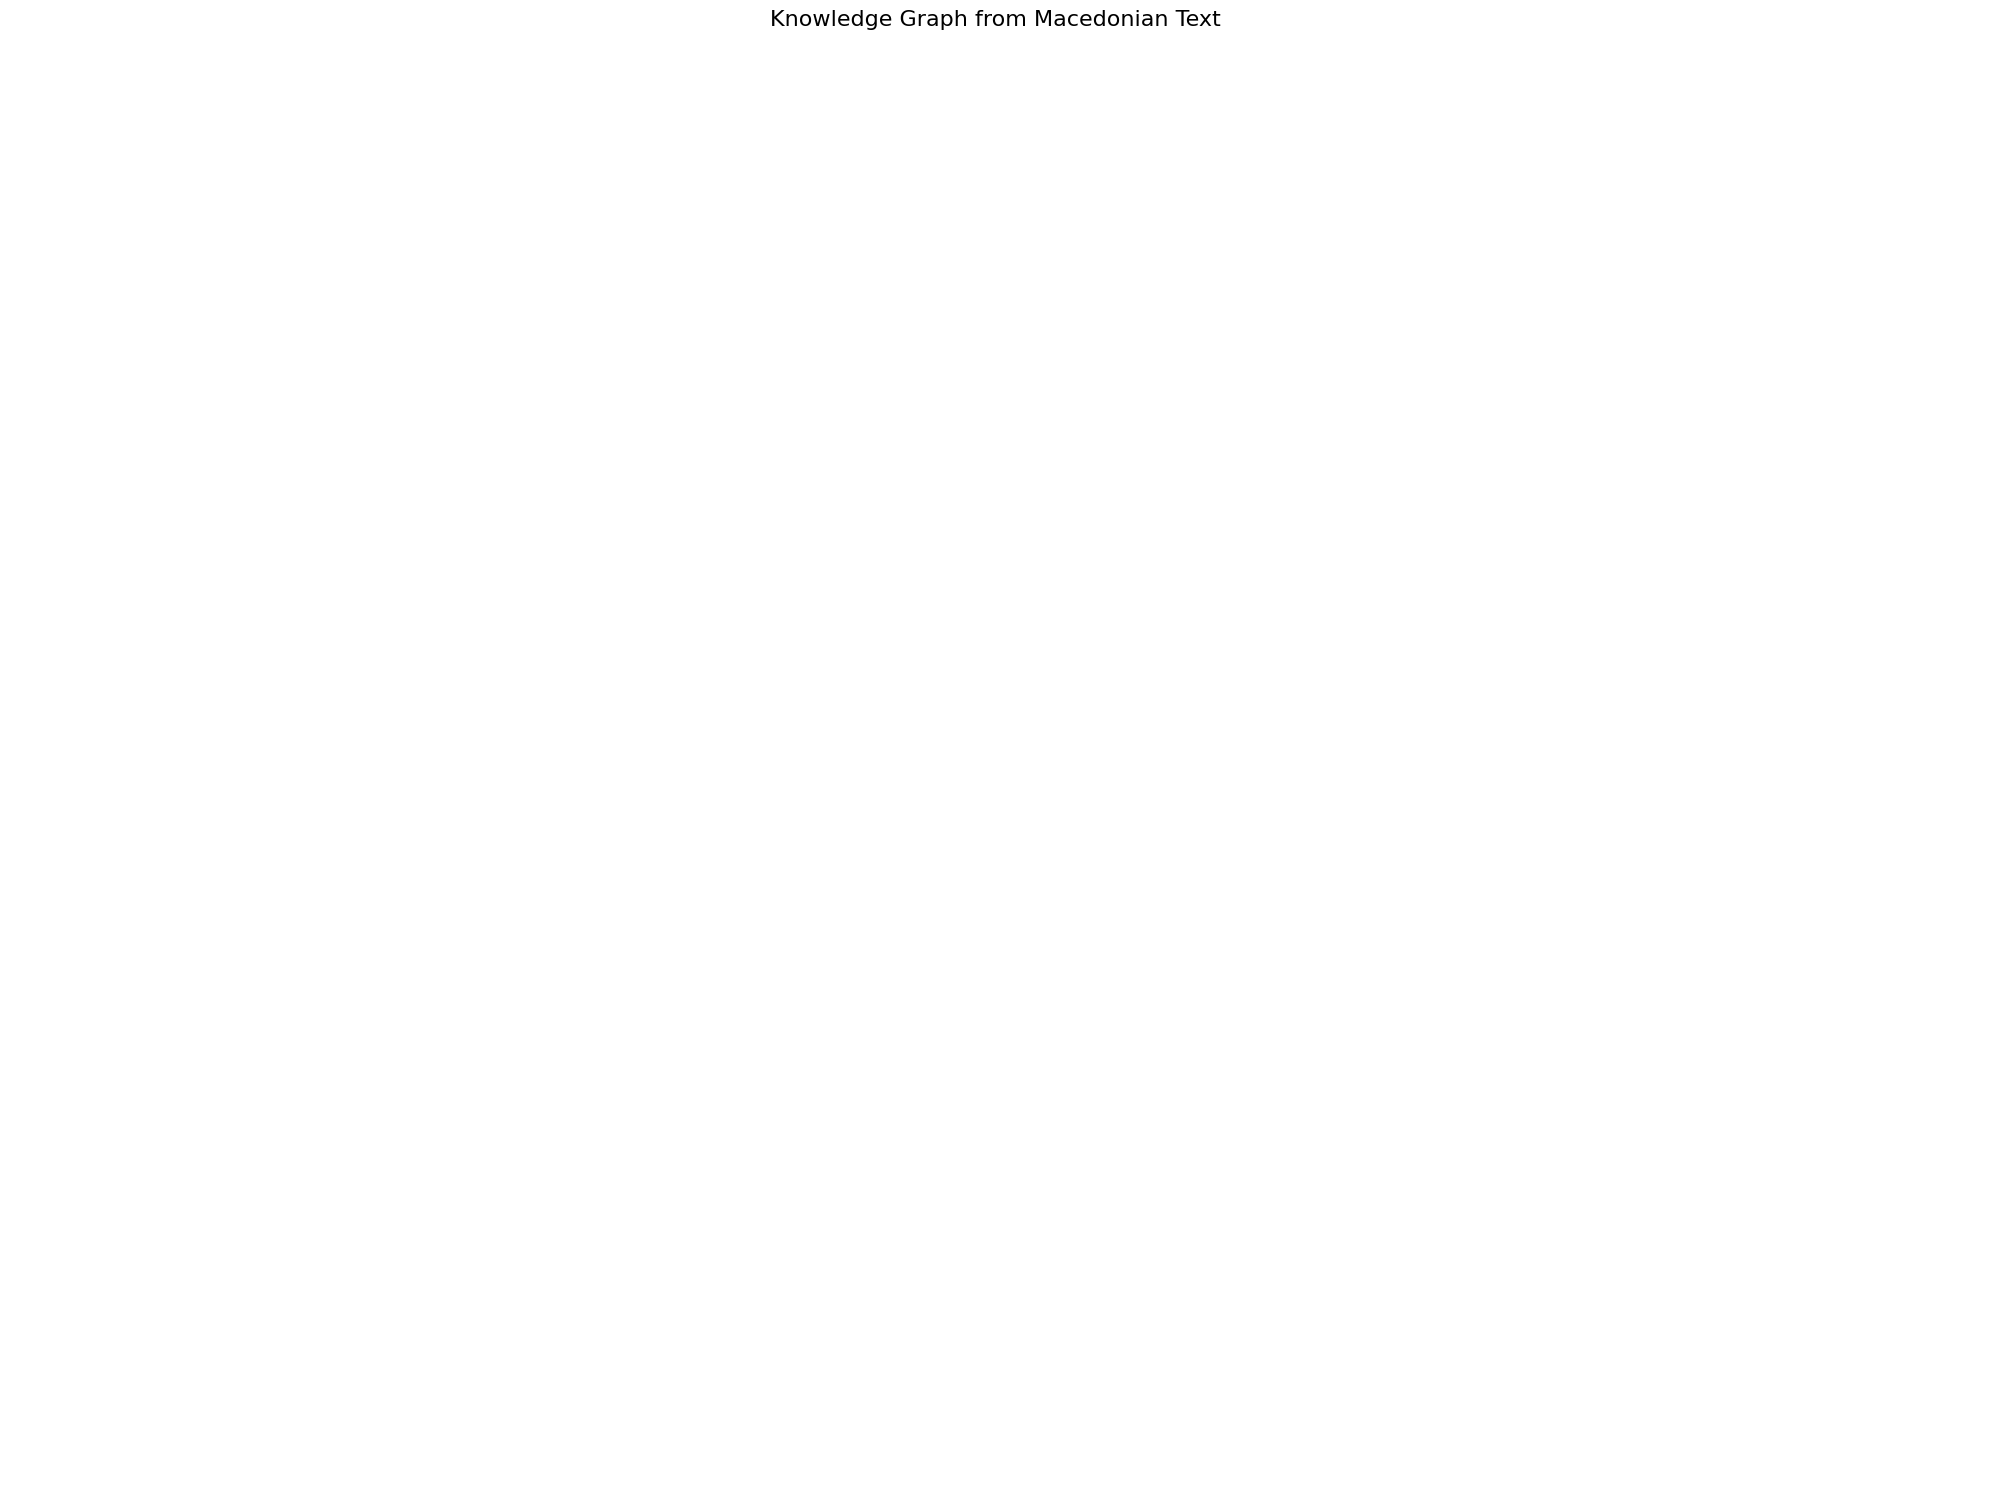

In [24]:
# Visualize the larger graph
plot_graph_matplotlib(kg_large, figsize=(20, 15))

In [ ]:
# Create interactive visualization with pyvis
visualize_graph(kg_large, output_file='macedonian_kg.html', notebook=False)

macedonian_kg.html
Graph visualization saved to macedonian_kg.html


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Query the Knowledge Graph

Let's explore specific entities in our knowledge graph.

In [ ]:
# List all entities in the graph
print("=== All Entities in Knowledge Graph ===")
entities = list(kg_large.graph.nodes())
print(f"Total entities: {len(entities)}")
print("\nFirst 20 entities:")
for i, entity in enumerate(entities[:20], 1):
    print(f"{i}. {entity}")

In [ ]:
# Query a specific entity (change this to an actual entity from your graph)
# You can use one from the list above
if entities:
    entity_to_query = entities[0]  # Query the first entity
    print(f"\n=== Information for: {entity_to_query} ===\n")
    
    info = kg_large.get_entity_info(entity_to_query)
    
    if info:
        print(f"Outgoing relations ({len(info['outgoing_relations'])}):")
        for subj, obj, edge_data in info['outgoing_relations']:
            for key, data in edge_data.items():
                relation = data.get('relation', 'unknown')
                print(f"  → {obj} [{relation}]")
        
        print(f"\nIncoming relations ({len(info['incoming_relations'])}):")
        for subj, obj, edge_data in info['incoming_relations']:
            for key, data in edge_data.items():
                relation = data.get('relation', 'unknown')
                print(f"  ← {subj} [{relation}]")

In [ ]:
# Export the knowledge graph triplets to JSON
kg_large.export_triplets('macedonian_kg_triplets.json')

## Advanced Analysis

Let's perform some advanced graph analysis to find interesting patterns.

In [ ]:
# Find most connected entities
print("=== Most Connected Entities ===\n")

degree_dict = dict(kg_large.graph.degree())
sorted_entities = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 10 entities by number of connections:")
for i, (entity, degree) in enumerate(sorted_entities[:10], 1):
    print(f"{i}. {entity}: {degree} connections")

# Find most common relations
print("\n=== Most Common Relations ===\n")

relation_counts = {}
for _, _, data in kg_large.graph.edges(data=True):
    relation = data.get('relation', 'unknown')
    relation_counts[relation] = relation_counts.get(relation, 0) + 1

sorted_relations = sorted(relation_counts.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most frequent relations:")
for i, (relation, count) in enumerate(sorted_relations[:10], 1):
    print(f"{i}. {relation}: {count} occurrences")